<a href="https://colab.research.google.com/github/cancan-lab/Notebook-DM2/blob/main/164221112_Rayya_Andina_Nathania_Tugas_Signal_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Praktikum Data Mining 2 — Signal Clustering (Heartbeat Sounds: **set_b**)**

Notebook ini menuntun kamu **end-to-end**:
1) **Data Preprocessing** (load metadata, ekstraksi fitur sinyal)
2) **Clustering** (K-Means + opsi Agglomerative/GMM)
3) **Evaluasi** (Silhouette, ARI, NMI, purity, confusion matrix)
4) **Interpretasi** (visualisasi & ringkasan temuan)

> **Catatan:** Dataset `set_b.zip` (berisi `.wav`) dan `set_b.csv` (metadata/label) wajib tersedia.

## **Setup Lingkungan**

In [ ]:
!pip -q install librosa==0.10.2.post1 umap-learn==0.5.6 scikit-learn==1.5.2 pandas==2.2.2 matplotlib==3.9.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 78.0 MB/s eta 0:00:00


## 1. Akses Data
Pilih salah satu cara:
- **Opsi A (Upload manual di Colab):** Upload `set_b.zip` dan `set_b.csv` saat diminta.
- **Opsi B (Google Drive):** Mount Drive lalu set `DATA_DIR` ke folder yang berisi file tersebut.
- **Opsi C (Local/VM):** Pastikan path file benar.

Set variabel `SET_B_ZIP` dan `SET_B_CSV` sesuai lokasi file.


In [ ]:
from pathlib import Path
import os

# ====== Pilih salah satu opsi ======
USE_COLAB_UPLOAD = True   # True untuk upload manual di Colab
USE_GOOGLE_DRIVE = False  # True jika mau mount GDrive

SET_B_ZIP = Path('set_b.zip')   # path default (akan terisi jika upload)
SET_B_CSV = Path('set_b.csv')   # path default (akan terisi jika upload)

if USE_COLAB_UPLOAD:
    try:
        from google.colab import files  # type: ignore
        print("Silakan upload 'set_b.zip' dan 'set_b.csv' ...")
        uploaded = files.upload()  # dialog upload
        # Simpan nama file yang terupload jika ada
        if 'set_b.zip' in uploaded:
            SET_B_ZIP = Path('set_b.zip')
        if 'set_b.csv' in uploaded:
            SET_B_CSV = Path('set_b.csv')
    except Exception as e:
        print("Sepertinya kamu tidak di Colab atau modul google.colab tidak ada. Lewati upload manual.")
        print("Error:", e)

if USE_GOOGLE_DRIVE:
    try:
        from google.colab import drive  # type: ignore
        drive.mount('/content/drive')
        # TODO: set path berikut ke folder yang benar di Drive kamu
        SET_B_ZIP = Path('/content/drive/MyDrive/datasets/heartbeat/set_b.zip')
        SET_B_CSV = Path('/content/drive/MyDrive/datasets/heartbeat/set_b.csv')
    except Exception as e:
        print("Tidak bisa mount Google Drive:", e)

print("SET_B_ZIP:", SET_B_ZIP.resolve())
print("SET_B_CSV:", SET_B_CSV.resolve())
assert SET_B_ZIP.exists(), "File set_b.zip tidak ditemukan. Sesuaikan path/opsi akses data."
assert SET_B_CSV.exists(), "File set_b.csv tidak ditemukan. Sesuaikan path/opsi akses data."


Silakan upload 'set_b.zip' dan 'set_b.csv' ...


SET_B_ZIP: /content/set_b.zip
SET_B_CSV: /content/set_b.csv


## 2. Ekstrak ZIP & Cek Struktur

In [ ]:
import zipfile

DATA_DIR = Path('data_set_b')
DATA_DIR.mkdir(exist_ok=True)

with zipfile.ZipFile(SET_B_ZIP, 'r') as zf:
    zf.extractall(DATA_DIR)

# Hitung jumlah wav
wav_files = list(DATA_DIR.rglob('*.wav'))
print(f"Jumlah file .wav: {len(wav_files)}")
# Tampilkan beberapa contoh path
for p in wav_files[:10]:
    print("-", p)


Jumlah file .wav: 656
- data_set_b/normal_noisynormal_115_1306259437619_B.wav
- data_set_b/normal_noisynormal_144_1306522408528_C.wav
- data_set_b/normal__140_1306519735121_D1.wav
- data_set_b/extrastole__151_1306779785624_B.wav
- data_set_b/murmur__203_1308162026258_B.wav
- data_set_b/extrastole__138_1306762146980_B.wav
- data_set_b/extrastole__134_1306428161797_C1.wav
- data_set_b/Bunlabelledtest__159_1307018640315_A.wav
- data_set_b/normal_noisynormal_142_1306763049574_D.wav
- data_set_b/Bunlabelledtest__187_1308073994223_C.wav


## 3. Muat Metadata (Label)

In [ ]:
import pandas as pd

meta = pd.read_csv(SET_B_CSV)
print("Kolom:", meta.columns.tolist())
print("Jumlah baris:", len(meta))
meta.head()


Kolom: ['dataset', 'fname', 'label', 'sublabel']
Jumlah baris: 656


,dataset,fname,label,sublabel
0,b,set_b/Btraining_extrastole_127_1306764300147_C...,extrastole,NaN
1,b,set_b/Btraining_extrastole_128_1306344005749_A...,extrastole,NaN
2,b,set_b/Btraining_extrastole_130_1306347376079_D...,extrastole,NaN
3,b,set_b/Btraining_extrastole_134_1306428161797_C...,extrastole,NaN
4,b,set_b/Btraining_extrastole_138_1306762146980_B...,extrastole,NaN


## 4. Data Preprocessing & Ekstraksi Fitur

Kita ekstrak fitur per rekaman (per file `.wav`):
- **MFCC (40 koefisien)**: mean & std → 80 fitur
- **Spectral features**: centroid, bandwidth, rolloff (mean & std)
- **Zero Crossing Rate**: mean & std
- **Chroma STFT**: mean (12 dim)
Total ≈ 99+ fitur per rekaman.

> Audio kita resample ke `sr=22050`. Durasi variatif ditangani dengan statistik (mean/std) sehingga vektor fitur berdimensi tetap.


In [ ]:
import librosa
import numpy as np
from tqdm import tqdm
from pathlib import Path
import re

SR = 22050  # sample rate target
N_MFCC = 40

def extract_features(path):
    try:
        y, sr = librosa.load(path, sr=SR, mono=True)
        if y is None or len(y) == 0:
            return None

        # MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
        mfcc_mean = mfcc.mean(axis=1)
        mfcc_std = mfcc.std(axis=1)

        # Spectral
        spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spec_roll = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)

        spec = np.array([
            spec_centroid.mean(), spec_centroid.std(),
            spec_bw.mean(), spec_bw.std(),
            spec_roll.mean(), spec_roll.std(),
            zcr.mean(), zcr.std()
        ])

        # Chroma
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = chroma.mean(axis=1)

        feat = np.concatenate([mfcc_mean, mfcc_std, spec, chroma_mean], axis=0)
        return feat
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None


candidate_name_cols = ['fname','filename','recording','wav','file']
name_col = None
for c in candidate_name_cols:
    if c in meta.columns:
        name_col = c
        break
assert name_col is not None, f"Tidak menemukan kolom nama file dari kandidat {candidate_name_cols}."

label_col = 'label' if 'label' in meta.columns else None
if label_col is None:
    # coba cari kolom dengan nama mirip
    for c in meta.columns:
        if 'label' in c.lower() or 'class' in c.lower():
            label_col = c
            break
assert label_col is not None, "Tidak menemukan kolom label di CSV. Pastikan ada kolom label."

# Create a map from a simplified filename (without 'noisynormal' or '__') to the full path
extracted_path_map = {}
for p in wav_files:
    stem = p.stem.lower()
    # Remove 'noisynormal' and '__' for simplified matching
    simplified_stem = stem.replace('noisynormal', '').replace('__', '_').replace('__', '_').strip('_')
    extracted_path_map[simplified_stem] = p


rows = []
missing = 0

for _, row in tqdm(meta.iterrows(), total=len(meta)):
    fname_in_meta = str(row[name_col])
    lbl = row[label_col]

    parts = Path(fname_in_meta).stem.lower().split('_')

    match = re.search(r'(btraining_|bunlabelledtest_)(.+)', Path(fname_in_meta).stem.lower())
    core_part = None
    if match:
        core_part = match.group(2)

    p = None
    if core_part:
        # Try to find a matching file in the extracted directory based on the core part
        p = extracted_path_map.get(core_part.replace('noisynormal', '').replace('__', '_').replace('__', '_').strip('_'), None)


    if p is None:
        missing += 1
        continue

    feat = extract_features(p)
    if feat is None:
        continue
    rows.append({
        'filename': str(p.name),
        'label': lbl,
        'path': str(p),
        'features': feat
    })

print("Rekaman yang hilang (tidak ditemukan di ZIP):", missing)
print("Sample sukses ekstraksi:", len(rows))
len(rows)

100%|██████████| 656/656 [00:36<00:00, 18.02it/s]

Rekaman yang hilang (tidak ditemukan di ZIP): 344
Sample sukses ekstraksi: 312


312

## 5. Bangun Tabel Fitur

In [ ]:
# Flatten fitur ke kolom numerik
feat_mat = np.stack([r['features'] for r in rows])
y_true = np.array([r['label'] for r in rows])
fnames = np.array([r['filename'] for r in rows])

feat_cols = []
for i in range(feat_mat.shape[1]):
    feat_cols.append(f"f_{i:03d}")

df_feat = pd.DataFrame(feat_mat, columns=feat_cols)
df_feat.insert(0, 'filename', fnames)
df_feat.insert(1, 'label', y_true)

print(df_feat.shape)
df_feat.head()


(312, 102)


,filename,label,f_000,f_001,f_002,f_003,f_004,f_005,f_006,f_007,...,f_090,f_091,f_092,f_093,f_094,f_095,f_096,f_097,f_098,f_099
0,extrastole__127_1306764300147_C2.wav,extrastole,-381.496948,148.527328,51.487808,-1.588717,9.028183,30.353085,23.353342,5.787520,...,0.706783,0.717909,0.753368,0.773290,0.737943,0.769557,0.752125,0.713676,0.704506,0.721647
1,extrastole__128_1306344005749_A.wav,extrastole,-438.495239,186.075577,64.372223,-1.205831,11.823222,35.722824,24.241791,2.467177,...,0.692304,0.716561,0.728408,0.727690,0.700263,0.694878,0.688555,0.674404,0.659878,0.675206
2,extrastole__130_1306347376079_D.wav,extrastole,-422.194489,193.339417,56.403858,-11.137746,11.076663,39.170448,21.525957,-6.296694,...,0.702257,0.655728,0.634226,0.617541,0.597001,0.642250,0.653644,0.660325,0.654068,0.645816
3,extrastole__134_1306428161797_C1.wav,extrastole,-450.566315,183.262436,40.861881,-22.946823,10.540374,45.312695,25.798367,-4.969388,...,0.699919,0.746569,0.782879,0.788221,0.771234,0.826302,0.781873,0.729126,0.709829,0.712490
4,extrastole__138_1306762146980_B.wav,extrastole,-385.793915,161.454239,50.383923,-7.904869,7.210165,31.577215,21.455750,1.239118,...,0.742389,0.769113,0.789007,0.776743,0.740966,0.764585,0.727310,0.704267,0.694275,0.697119


## 6. Reduksi Dimensi untuk Visualisasi (PCA → UMAP)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap

X = df_feat[feat_cols].values.astype('float32')
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# PCA ke 50 komponen (untuk stabilisasi UMAP)
pca = PCA(n_components=min(50, X_std.shape[1]), random_state=42)
X_pca = pca.fit_transform(X_std)

# UMAP ke 2D (untuk plot)
umap_2d = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_2d = umap_2d.fit_transform(X_pca)

X_2d[:5]


array([[0.92904276, 7.818952  ],
       [1.4581852 , 8.383804  ],
       [3.8183973 , 7.9808035 ],
       [4.5500135 , 6.3645606 ],
       [1.6664106 , 6.2962008 ]], dtype=float32)

### Visualisasi 2D berdasarkan **Label Asli**

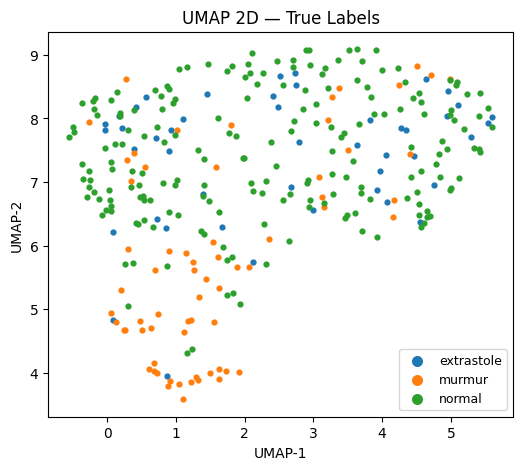

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels_unique = np.unique(y_true)

plt.figure(figsize=(6,5))
for lab in labels_unique:
    idx = (y_true == lab)
    plt.scatter(X_2d[idx,0], X_2d[idx,1], s=12, label=str(lab))
plt.title("UMAP 2D — True Labels")
plt.legend(markerscale=2, fontsize=9)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


## 7. Clustering (K-Means utama, opsi Agglomerative & GMM)

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

n_clusters = len(np.unique(y_true)) if len(np.unique(y_true))>=2 else 4  # default 4 kelas set_b
print("n_clusters:", n_clusters)

# K-Means
kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)
y_km = kmeans.fit_predict(X_std)

# Agglomerative
agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
y_agg = agg.fit_predict(X_std)

# GMM
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
y_gmm = gmm.fit_predict(X_std)

print("Selesai fit tiga metode clustering.")


n_clusters: 3
Selesai fit tiga metode clustering.


## 8. Evaluasi (Internal & External)

In [ ]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
import numpy as np
import pandas as pd # Import pandas to use categorical conversion

def purity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return np.sum(np.max(cm, axis=0)) / np.sum(cm)

def eval_all(name, y_pred, X_emb, y_true_numeric):
    sil = silhouette_score(X_emb, y_pred) if len(np.unique(y_pred))>1 else float('nan')
    ari = adjusted_rand_score(y_true_numeric, y_pred)
    nmi = normalized_mutual_info_score(y_true_numeric, y_pred)
    pur = purity_score(y_true_numeric, y_pred)
    print(f"[{name}] Silhouette={sil:.3f} | ARI={ari:.3f} | NMI={nmi:.3f} | Purity={pur:.3f}")
    return {'model': name, 'silhouette': sil, 'ari': ari, 'nmi': nmi, 'purity': pur}

# Convert y_true (string labels) to numerical codes
y_true_numeric = pd.Categorical(y_true).codes

results = []
results.append(eval_all("KMeans", y_km, X_std, y_true_numeric))
results.append(eval_all("Agglomerative", y_agg, X_std, y_true_numeric))
results.append(eval_all("GMM", y_gmm, X_std, y_true_numeric))

df_eval = pd.DataFrame(results)
df_eval

[KMeans] Silhouette=0.133 | ARI=0.117 | NMI=0.116 | Purity=0.712
[Agglomerative] Silhouette=0.129 | ARI=0.061 | NMI=0.097 | Purity=0.689
[GMM] Silhouette=0.122 | ARI=0.098 | NMI=0.104 | Purity=0.705


,model,silhouette,ari,nmi,purity
0,KMeans,0.132716,0.116517,0.115669,0.711538
1,Agglomerative,0.129339,0.061060,0.096586,0.689103
2,GMM,0.121604,0.097919,0.103781,0.705128


### Confusion Matrix & Mapping Cluster → Label Mayoritas

In [ ]:
def cluster_label_mapping(y_true_numeric, y_pred):
    cm = confusion_matrix(y_true_numeric, y_pred)
    mapping = {}
    # Get the unique true labels to map cluster indices back to original labels
    unique_true_labels = pd.Categorical(y_true).categories.tolist()
    for c in range(cm.shape[1]):
        # Find the index of the majority true label for this cluster
        majority_label_index = np.argmax(cm[:, c])
        # Map the cluster index to the original string label
        mapping[c] = unique_true_labels[majority_label_index]
    return mapping, cm

# Need y_true from previous cells
# Need y_true_numeric from previous cells
# Need y_km, y_agg, y_gmm from previous cells

for name, y_pred in [("KMeans", y_km), ("Agglomerative", y_agg), ("GMM", y_gmm)]:
    mapping, cm = cluster_label_mapping(y_true_numeric, y_pred)
    print(f"\n=== {name} ===")
    print("Confusion matrix (rows=true label, cols=cluster):")
    # Print confusion matrix with true label names
    unique_true_labels = pd.Categorical(y_true).categories.tolist()
    cm_df = pd.DataFrame(cm, index=unique_true_labels, columns=[f'Cluster {i}' for i in range(cm.shape[1])])
    print(cm_df)
    print("Mapping cluster->label:", mapping)


=== KMeans ===
Confusion matrix (rows=true label, cols=cluster):
            Cluster 0  Cluster 1  Cluster 2
extrastole         26         18          2
murmur             20         13         33
normal            117         72         11
Mapping cluster->label: {0: 'normal', 1: 'normal', 2: 'murmur'}

=== Agglomerative ===
Confusion matrix (rows=true label, cols=cluster):
            Cluster 0  Cluster 1  Cluster 2
extrastole         29         16          1
murmur             43          5         18
normal            140         57          3
Mapping cluster->label: {0: 'normal', 1: 'normal', 2: 'murmur'}

=== GMM ===
Confusion matrix (rows=true label, cols=cluster):
            Cluster 0  Cluster 1  Cluster 2
extrastole         21         23          2
murmur             22         14         30
normal            100         90         10
Mapping cluster->label: {0: 'normal', 1: 'normal', 2: 'murmur'}


### Visualisasi 2D berdasarkan **Cluster Assignment**

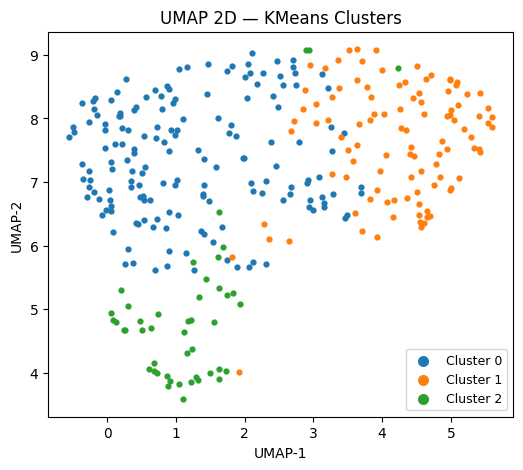

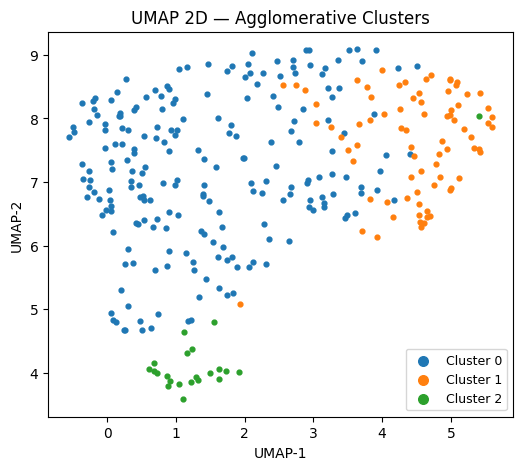

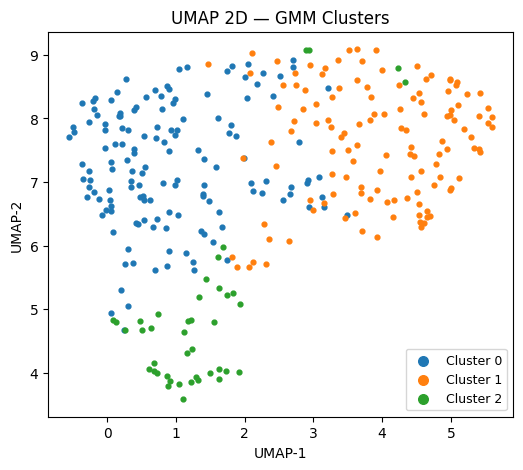

In [ ]:
def plot_clusters(X2d, y_pred, title):
    import matplotlib.pyplot as plt
    import numpy as np
    plt.figure(figsize=(6,5))
    for c in np.unique(y_pred):
        idx = (y_pred == c)
        plt.scatter(X2d[idx,0], X2d[idx,1], s=12, label=f"Cluster {c}")
    plt.title(title)
    plt.legend(markerscale=2, fontsize=9)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.show()

plot_clusters(X_2d, y_km, "UMAP 2D — KMeans Clusters")
plot_clusters(X_2d, y_agg, "UMAP 2D — Agglomerative Clusters")
plot_clusters(X_2d, y_gmm, "UMAP 2D — GMM Clusters")


^C
Contoh file: data_set_b/Bunlabelledtest__101_1305030823364_A.wav


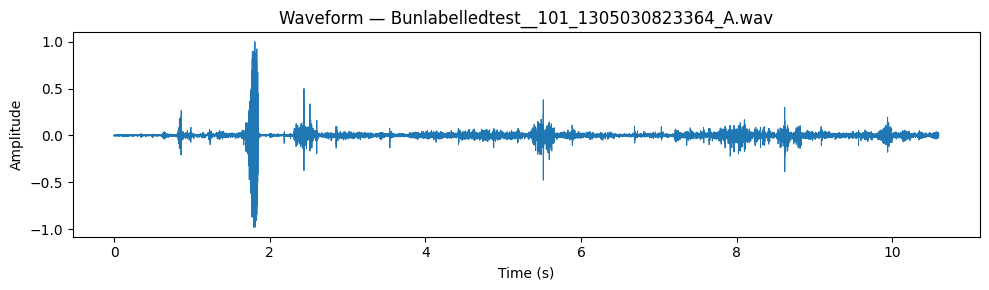

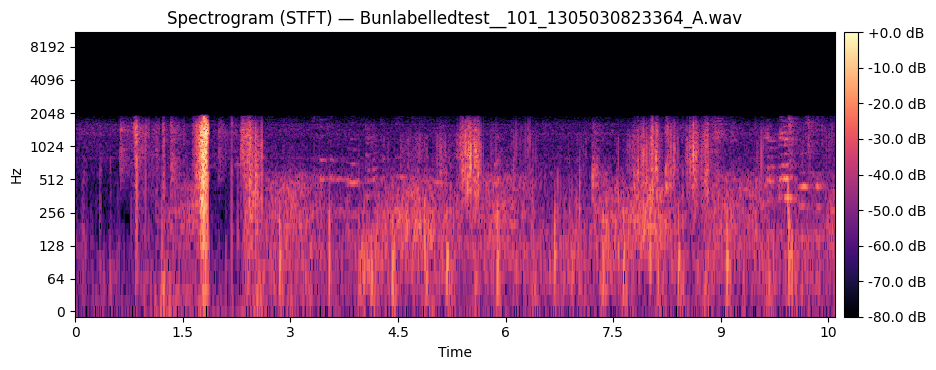

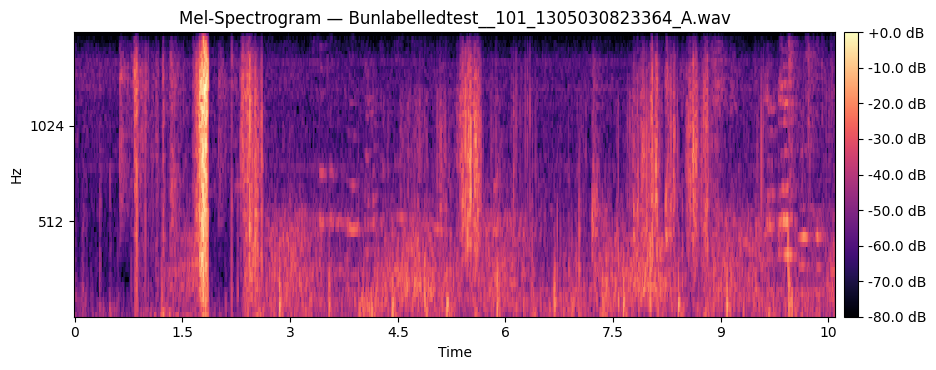

In [ ]:
# --- 0) Install & import ---
!pip -q install librosa==0.10.2.post1 matplotlib==3.9.2

import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob

# --- 1) Pilih file audio ---
# Jika sudah ekstrak set_b.zip ke folder "data_set_b", cari file .wav:
wav_files = sorted(glob("data_set_b/**/*.wav", recursive=True))
if len(wav_files) == 0:
    print("Belum ada .wav. Upload atau ekstrak set_b.zip dulu ya.")
else:
    print("Contoh file:", wav_files[0])

# Atau set manual:
AUDIO_PATH = wav_files[0]  # ganti jika perlu, mis. AUDIO_PATH = "data_set_b/btraining-normal/xxx.wav"

# --- 2) Utility plot ---
def plot_waveform(y, sr, title="Waveform"):
    t = np.arange(len(y)) / sr
    plt.figure(figsize=(10, 3))
    plt.plot(t, y, linewidth=0.7)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

def plot_stft_spectrogram(y, sr, n_fft=1024, hop_length=256, fmin=20, fmax=None, title="Spectrogram (STFT, dB)"):
    # Power spectrogram
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))**2
    S_db = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 3.8))
    librosa.display.specshow(
        S_db, sr=sr, hop_length=hop_length,
        x_axis='time', y_axis='log', fmin=fmin, fmax=fmax
    )
    plt.title(title)
    plt.colorbar(format="%+0.1f dB", pad=0.01)
    plt.tight_layout()
    plt.show()

def plot_mel_spectrogram(y, sr, n_fft=1024, hop_length=256, n_mels=64, fmin=20, fmax=8000, title="Mel-Spectrogram (dB)"):
    S_mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, fmin=fmin, fmax=fmax, power=2.0
    )
    S_mel_db = librosa.power_to_db(S_mel, ref=np.max)

    plt.figure(figsize=(10, 3.8))
    librosa.display.specshow(
        S_mel_db, sr=sr, hop_length=hop_length,
        x_axis='time', y_axis='mel', fmin=fmin, fmax=fmax
    )
    plt.title(title)
    plt.colorbar(format="%+0.1f dB", pad=0.01)
    plt.tight_layout()
    plt.show()

# --- 3) Load & plot ---
# Gunakan sr=22050 (standar audio speech/heartbeat) agar konsisten antar-berkas.
y, sr = librosa.load(AUDIO_PATH, sr=22050, mono=True)

# (Opsional) Normalisasi ringan supaya skala amplitudo seragam
if np.max(np.abs(y)) > 0:
    y = y / np.max(np.abs(y))

plot_waveform(y, sr, title=f"Waveform — {Path(AUDIO_PATH).name}")
plot_stft_spectrogram(y, sr, n_fft=1024, hop_length=256, fmin=20, fmax=2000,
                      title=f"Spectrogram (STFT) — {Path(AUDIO_PATH).name}")
plot_mel_spectrogram(y, sr, n_fft=1024, hop_length=256, n_mels=64, fmin=20, fmax=2000,
                     title=f"Mel-Spectrogram — {Path(AUDIO_PATH).name}")
